# CABNet Diabetic Retinopathy Classification
## for DDR Dataset

**Hardware**: RTX 4050 Laptop (6GB VRAM)
**Constraints**: < 1.5 Hours Training, Memory Efficient
**Architecture**: MobileNetV2 + CAB (Channel & Spatial Attention)



In [1]:
import os
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from torch.cuda.amp import GradScaler, autocast  # Mixed Precision

# Seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


## Configuration & Hardware Check
We attempt to use Batch Size 32. If an OOM error occurs during dummy forward pass, we fallback to 16.



In [2]:
DATA_DIR = "./data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
MODEL_SAVE_PATH = "./models"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Hyperparameters
NUM_CLASSES = 5
INPUT_SIZE = 224
EPOCHS = 20
LEARNING_RATE = 1e-4

# Auto-select Batch Size
def get_optimal_batch_size():
    # Simple heuristic or try-catch allocation
    print("Checking optimal batch size...")
    try:
        # Try batch size 32
        dummy_input = torch.randn(32, 3, 224, 224).to(device)
        del dummy_input
        torch.cuda.empty_cache()
        print("Selected Batch Size: 32")
        return 32
    except RuntimeError as e:
        print("Batch Size 32 failed, falling back to 16.")
        return 16

BATCH_SIZE = get_optimal_batch_size()



Checking optimal batch size...
Selected Batch Size: 32


## Dataset Preparation
Using Standard ImageFolder structure.



In [3]:
# Transforms
# MobileNetV2 expects normalization with ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Dataset Sizes: {dataset_sizes}")



Classes: ['0', '1', '2', '3', '4']
Dataset Sizes: {'train': 9959, 'val': 2563}


## CABNet Model Architecture
**Backbone**: MobileNetV2 (Pretrained)
**Attention**: Split into Channel Attention and Spatial (Global) Attention branches.



In [4]:
class CAB(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CAB, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class GAB(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(GAB, self).__init__()
        self.conv_s = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        attn = self.conv_s(x)
        return x * attn

class CABNet(nn.Module):
    def __init__(self, num_classes=5):
        super(CABNet, self).__init__()
        self.backbone = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        self.features = self.backbone.features
        
        self.cab = CAB(1280)
        self.gab = GAB(1280)
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2), # Default for MobileNetV2
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cab(x)
        x = self.gab(x)
        x = self.classifier(x)
        return x

model = CABNet(num_classes=NUM_CLASSES)
model = model.to(device)



## Training Setup
- **Loss**: CrossEntropyLoss
- **Optimizer**: Adam (lr=1e-4) -> Stable for Attention models
- **Scheduler**: CosineAnnealing
- **AMP**: Enabled for RTX 4050
- **Early Stopping**: Patience = 5



In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0



C:\Users\Sabyasachi Samanta\AppData\Local\Temp\ipykernel_29044\2855028469.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    early_stopper = EarlyStopping(patience=5)

    # Freeze Backbone initially (First 5 epochs)
    print("Freezing backbone layers...")
    for param in model.backbone.parameters():
        param.requires_grad = False
        
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Unfreeze after 5 epochs
        if epoch == 5:
            print("Unfreezing backbone layers...")
            for param in model.backbone.parameters():
                param.requires_grad = True

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            # Use tqdm if you want, simpler print here for cleanliness
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # AMP Context
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val':
                scheduler.step()
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{MODEL_SAVE_PATH}/ddr_cabnet_best.pth")
                
                early_stopper(epoch_loss)
        
        if early_stopper.early_stop:
            print("Early stopping triggered")
            break

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Run Training
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS)



Freezing backbone layers...
Epoch 1/20
----------


C:\Users\Sabyasachi Samanta\AppData\Local\Temp\ipykernel_29044\3612216137.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


train Loss: 1.0541 Acc: 0.5765
val Loss: 0.9118 Acc: 0.6391

Epoch 2/20
----------
train Loss: 0.8685 Acc: 0.6622
val Loss: 0.8161 Acc: 0.6883

Epoch 3/20
----------
train Loss: 0.8090 Acc: 0.6874
val Loss: 0.7815 Acc: 0.6957

Epoch 4/20
----------
train Loss: 0.7882 Acc: 0.6946
val Loss: 0.7604 Acc: 0.7062

Epoch 5/20
----------
train Loss: 0.7716 Acc: 0.7005
val Loss: 0.7592 Acc: 0.7132

Epoch 6/20
----------
Unfreezing backbone layers...
train Loss: 0.7056 Acc: 0.7359
val Loss: 0.6211 Acc: 0.7729

Epoch 7/20
----------
train Loss: 0.5816 Acc: 0.7821
val Loss: 0.5630 Acc: 0.7963

Epoch 8/20
----------
train Loss: 0.5085 Acc: 0.8141
val Loss: 0.5295 Acc: 0.8080

Epoch 9/20
----------
train Loss: 0.4563 Acc: 0.8314
val Loss: 0.5310 Acc: 0.8030

Epoch 10/20
----------
train Loss: 0.4226 Acc: 0.8430
val Loss: 0.5249 Acc: 0.8115

Epoch 11/20
----------
train Loss: 0.3873 Acc: 0.8552
val Loss: 0.5250 Acc: 0.8162

Epoch 12/20
----------
train Loss: 0.3457 Acc: 0.8702
val Loss: 0.5568 Acc: 0

## Evaluation & Visualization



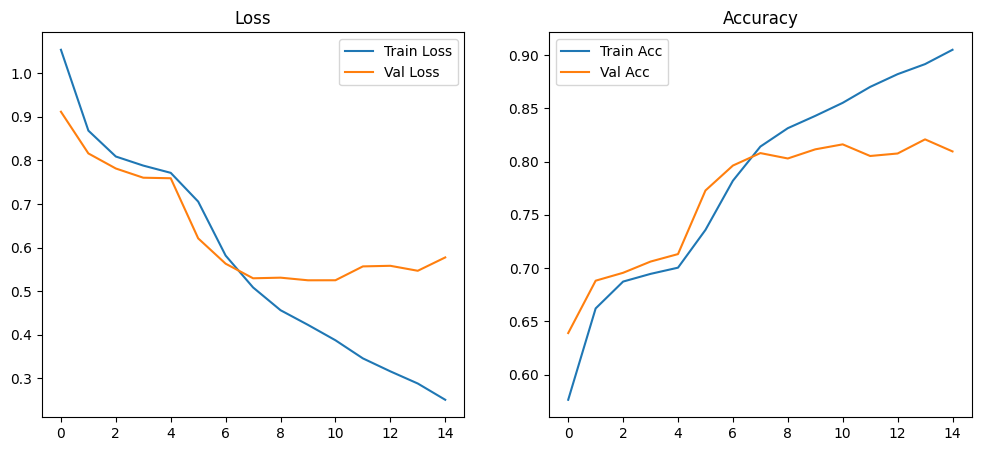

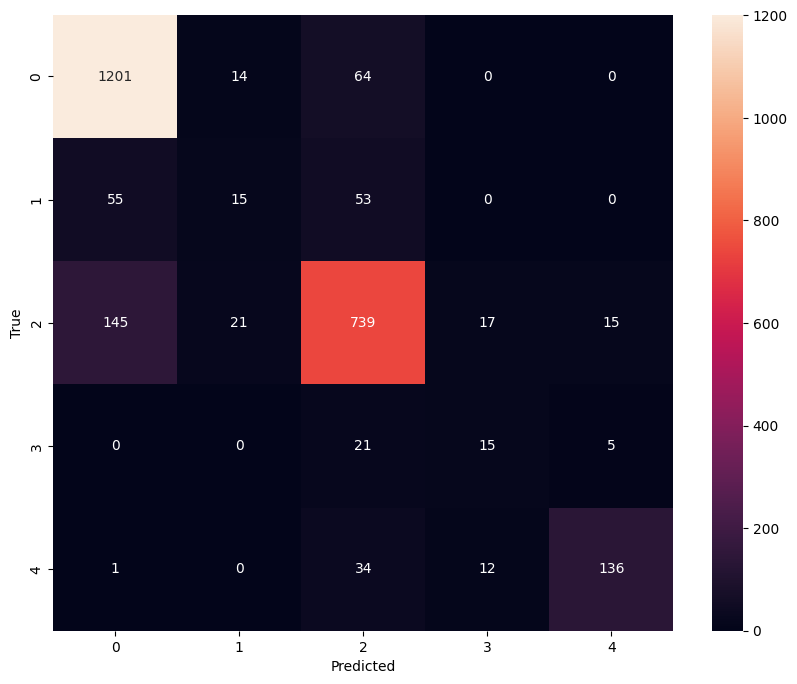

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1279
           1       0.30      0.12      0.17       123
           2       0.81      0.79      0.80       937
           3       0.34      0.37      0.35        41
           4       0.87      0.74      0.80       183

    accuracy                           0.82      2563
   macro avg       0.64      0.59      0.60      2563
weighted avg       0.81      0.82      0.81      2563



In [7]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion Matrix
def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print(classification_report(all_labels, all_preds, target_names=class_names))

plot_confusion_matrix(model, dataloaders['val'])

